In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pandas_profiling
import math
import statistics as stats
import folium

from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression, RFECV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [490]:
# pandas settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [161]:
# create df from cleaned listings data
listings_cleaned = pd.read_csv('listings_cleaned.csv')
# print out the shape of the df
print(listings_cleaned.shape)

(22126, 40)


In [162]:
listings_cleaned.drop(columns='Unnamed: 0', inplace=True)

In [163]:
listings_cleaned.head()

host_response_time  host_response_rate  host_is_superhost  host_listings_count  host_identity_verified  market  latitude  longitude property_type        room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  minimum_nights  maximum_nights  availability_30  availability_365  number_of_reviews  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  instant_bookable          cancellation_policy  calculated_host_listings_count  calculated_host_listings_count_private_rooms  calculated_host_listings_count_shared_rooms  reviews_per_month  years_as_host  num_host_verifications
0        within a day           95.976389                0.0                  1.0                     1.0  Dublin  53.34940   -6.34664         House  Entire home/apt             2        1.0       1.0   1.0   90.0               0.0          20.0                2          30.0               1            1125                0                 0                 11                 100.0                    10.0                       10.0                   10.0                         10.0                     9.0                 10.0                 0                     flexible                               1                                             0                                            0               0.40              5                       6
1  within a few hours          100.000000                0.0                  1.0                     0.0  Dublin  53.34827   -6.34590         House      Shared room             1        1.0       1.0   1.0   30.0               0.0          20.0                1           0.0               5            1125               19                79                  4                  90.0                     9.0                        8.0                   10.0                         10.0                     9.0                 10.0                 0                     flexible                               1                                             0                                            1               0.32              2                       5
2      within an hour          100.000000                0.0                  2.0                     1.0  Dublin  53.33558   -6.36881     Apartment     Private room             3        1.0       0.0   3.0   50.0             300.0          20.0                2          25.0               2            1125                5                43                109                  76.0                     8.0                        8.0                    9.0                          9.0                     8.0                  7.0                 1  strict_14_with_grace_period                               3                                             3                                            0               2.04              5                       5
3        within a day           95.976389                0.0                  1.0                     1.0  Dublin  53.33589   -6.32771     Townhouse  Entire home/apt             2        1.0       1.0   1.0   65.0               0.0          20.0                1           0.0               3            1125                0                 0                  3                  93.0                     9.0                        9.0                    7.0                          9.0                     9.0                 10.0                 0                     flexible                               1                                             0                                            0               0.21              5                       7
4      within an hour          100.000000                1.0                  1.0                     0.0  Dublin  53.33303   -6.32546    Guesthouse  Entire home/apt             2        1.0       1

In [164]:
listings_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22126 entries, 0 to 22125
Data columns (total 39 columns):
host_response_time                              22126 non-null object
host_response_rate                              22126 non-null float64
host_is_superhost                               22126 non-null float64
host_listings_count                             22126 non-null float64
host_identity_verified                          22126 non-null float64
market                                          22126 non-null object
latitude                                        22126 non-null float64
longitude                                       22126 non-null float64
property_type                                   22126 non-null object
room_type                                       22126 non-null object
accommodates                                    22126 non-null int64
bathrooms                                       22126 non-null float64
bedrooms                                     

In [165]:
report = pandas_profiling.ProfileReport(listings_cleaned)
report

In [166]:
listings_cleaned.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'market', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'calculated_host_listings_count', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'years_as_host', 'num_host_verifications'], dtype='object')

In [167]:
listings_cleaned['calculated_host_listings_count_shared_rooms'].value_counts() * 100 / len(listings_cleaned)

0     98.436229
1      0.926512
3      0.198861
2      0.198861
14     0.090391
4      0.072313
7      0.049715
5      0.027117
Name: calculated_host_listings_count_shared_rooms, dtype: float64

In [168]:
# about 99% of values are 0, not very usefull 
listings_cleaned.drop(columns='calculated_host_listings_count_shared_rooms', inplace=True)

In [169]:
# large outliers in price, clip top ~5% to remove
listings_cleaned.query('price >= 210').price.count() * 100 / len(listings_cleaned)

4.8720961764440025

In [170]:
listings_cleaned = listings_cleaned[listings_cleaned['price'] <= 210]
listings_cleaned.shape

(21065, 38)

In [439]:
listings_cleaned.to_csv('listings_for_db.csv', index=False)

## split in to train and text


In [171]:
# target
target = 'price'

#features
features = listings_cleaned.columns.to_list()
features.remove(target)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(listings_cleaned[features], listings_cleaned[target], test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16852, 37) (16852,)
(4213, 37) (4213,)


## baseline model using mean price

In [173]:
mean_price = np.mean(listings_cleaned['price'])
mean_price

81.72219321148825

In [174]:
y_pred = np.full_like(y_test, fill_value=mean_price)
print(len(y_test), len(y_pred))

4213 4213


In [175]:
baseline_mae = mean_absolute_error(y_test, y_pred)
baseline_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
baseline_R2 = r2_score(y_test, y_pred)

In [176]:
print(f'MAE: {baseline_mae}')
print(f'RMSE: {baseline_rmse}')
print(f'R^2: {baseline_R2}')

MAE: 33.02482506279519
RMSE: 41.905876659274696
R^2: -6.518820758016908e-05


## create a regression model

In [177]:
X_train.describe(exclude='number')

host_response_time  market property_type        room_type cancellation_policy
count               16852   16852         16852            16852               16852
unique                  4      28            42                4                   6
top        within an hour  Dublin         House  Entire home/apt            flexible
freq                 9692    5136          6187             8817                6499

In [196]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [179]:
X_train.shape

(16852, 116)

In [180]:
model = LinearRegression()

In [181]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [182]:
reg_mae = mean_absolute_error(y_test, y_pred)
reg_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
reg_r2 = r2_score(y_test, y_pred)

print(f"MAE: {reg_mae}")
print(f"RMSE: {reg_rmse}")
print(f"R2: {reg_r2}\n")

print("Variable coefficients")
print('-'*25)
for i in range(len(features)):
  print(f"{features[i]}: {model.coef_[i]}")
  
print(f"\nIntercept: {model.intercept_}")

MAE: 22.705493049256035
RMSE: 30.158103671037967
R2: 0.48205158458953346

Variable coefficients
-------------------------
host_response_time: 3.2507222791945365
host_response_rate: -0.5886657645659176
host_is_superhost: 1.4174276597512834
host_listings_count: -4.079484174384165
host_identity_verified: -0.059853012099305936
market: 0.5201349254704283
latitude: 0.019716992808355815
longitude: 1.0553721366389919
property_type: 20.232180310898467
room_type: -2.030803950709063
accommodates: -4.198030867599625
bathrooms: 6.753331333371836
bedrooms: -8.181586103949506
beds: -0.19426409371177236
security_deposit: 10.460828131188247
cleaning_fee: -1.541860762596074
guests_included: 1.4130624949970902
extra_people: 8.10007720465363
minimum_nights: 5.661960047772146
maximum_nights: -1.6294938259695453
availability_30: -7.606627671925605
availability_365: -8.101480376013223
number_of_reviews: 8.318295605662339
review_scores_rating: 2.893452819023215
review_scores_accuracy: 1.3641890895397442
revie

In [183]:
selector_f = SelectPercentile(f_regression, percentile=25)
selector_f.fit(X_train, y_train)

for feature,score in zip(features, selector_f.scores_):
    print(f'F-score {score} for feature {feature}')

F-score 110.16354571823607 for feature host_response_time
F-score 144.33749842936572 for feature host_response_rate
F-score 13.252698905217416 for feature host_is_superhost
F-score 0.014235193663311548 for feature host_listings_count
F-score 10.55354043750604 for feature host_identity_verified
F-score 92.31715487954278 for feature market
F-score 66.28200387646474 for feature latitude
F-score 7.185804376112475 for feature longitude
F-score 87.62837084733412 for feature property_type
F-score 0.17328123906353773 for feature room_type
F-score 3.9355355556301554 for feature accommodates
F-score 24.247684023810326 for feature bathrooms
F-score 13.544028388603788 for feature bedrooms
F-score 9.363468541280703 for feature beds
F-score 2.9810188492120657 for feature security_deposit
F-score 31.263911766356713 for feature cleaning_fee
F-score 1.5807637700378294 for feature guests_included
F-score 1.3942566709993238 for feature extra_people
F-score 45.31592514925097 for feature minimum_nights
F-s

## Regression using results from f_regression

In [189]:
# target
f_target = 'price'

#features
f_features = [
    'host_response_time',
    'host_response_rate',
    'market',
    'property_type',
    'latitude',
    'bathrooms',
    'cleaning_fee',
    'minimum_nights',
    'cancellation_policy',
    'review_scores_rating'
]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(listings_cleaned[f_features], listings_cleaned[f_target], test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16852, 10) (16852,)
(4213, 10) (4213,)


In [191]:
X_train.head()

host_response_time  host_response_rate                 market property_type  latitude  bathrooms  cleaning_fee  minimum_nights          cancellation_policy  review_scores_rating
8390         within a day           95.976389                 Dublin     Apartment  53.32831        1.0          20.0               2                     moderate                  98.0
317        within an hour          100.000000                 Dublin         House  53.38806        1.0          10.0               1                     flexible                 100.0
6385       within an hour          100.000000  Other (International)     Apartment  53.49331        1.0          35.0               1  strict_14_with_grace_period                  99.0
11524      within an hour          100.000000  Other (International)      Bungalow  55.12741        1.0          20.0               1                     moderate                  98.0
6535   within a few hours          100.000000                 Tralee     Farm stay  52.12023        1.0          20.0               2                     flexible                 100.0

In [192]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [193]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f_reg_mae = mean_absolute_error(y_test, y_pred)
f_reg_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
f_reg_r2 = r2_score(y_test, y_pred)

print(f"MAE: {f_reg_mae}")
print(f"RMSE: {f_reg_rmse}")
print(f"R2: {f_reg_r2}\n")

print("Variable coefficients")
print('-'*25)
for i in range(len(f_features)):
  print(f"{f_features[i]}: {model.coef_[i]}")
  
print(f"\nIntercept: {model.intercept_}")

MAE: 27.09112651688227
RMSE: 35.48693362580982
R2: 0.28284109147778713

Variable coefficients
-------------------------
host_response_time: -14017295911955.273
host_response_rate: -14017295911959.52
market: -14017295911957.332
property_type: -14017295911967.389
latitude: -0.080078125
bathrooms: 4.97265625
cleaning_fee: 0.435546875
minimum_nights: -0.9052734375
cancellation_policy: -0.2109375
review_scores_rating: -5.96484375

Intercept: 14017295912101.152


## Random forest regression

In [197]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [198]:
y_pred = rf.predict(X_test)

In [208]:
rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
rf_r2 = r2_score(y_test, y_pred)

print(f"MAE: {rf_mae}")
print(f"RMSE: {rf_rmse}")
print(f"R2: {rf_r2}\n")

MAE: 18.97300973178258
RMSE: 26.475710171337564
R2: 0.6008154853267068



## Hyperparamater tunning

In [217]:
n_estimators = [int(x) for x in range(200, 2200, 200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [219]:
rf_random = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.9min
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 74.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                                                   oob_score=False,
                                                   random_state=42...


In [220]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [223]:
rf_best = RandomForestRegressor(
    n_estimators=1400, 
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=100,
    bootstrap=True,
    random_state=42, 
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1400,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [228]:
y_pred = rf_best.predict(X_test)

In [229]:
rf_mae_best = mean_absolute_error(y_test, y_pred)
rf_rmse_best = math.sqrt(mean_squared_error(y_test, y_pred))
rf_r2_best = r2_score(y_test, y_pred)

print(f"MAE: {rf_mae_best}")
print(f"RMSE: {rf_rmse_best}")
print(f"R2: {rf_r2_best}\n")

MAE: 18.83308500898579
RMSE: 26.362108924121504
R2: 0.6042337558676983



In [230]:
feature_importance = pd.DataFrame(rf_best.feature_importances_,
                                 index = X_train.columns,
                                 columns=['importance']).sort_values('importance', ascending=False)

In [232]:
feature_importance.head(10)

importance
room_type_Entire home/apt    0.283369
longitude                    0.056158
latitude                     0.051403
accommodates                 0.043592
bedrooms                     0.042431
market_Dublin                0.041716
bathrooms                    0.040207
reviews_per_month            0.040197
extra_people                 0.030202
number_of_reviews            0.027047

## Compare scores from all models

In [435]:
print('metrics for baseline model:')
print('-'*20)
print(f'MAE: {baseline_mae}')
print(f'RMSE: {baseline_rmse}')
print(f'R^2: {baseline_R2}')

print('\nmetrics for linear regression model:')
print('-'*20)
print(f"MAE: {reg_mae}")
print(f"RMSE: {reg_rmse}")
print(f"R2: {reg_r2}")

print('\nmetrics for linear regression model using feature selection:')
print('-'*20)
print(f"MAE: {f_reg_mae}")
print(f"RMSE: {f_reg_rmse}")
print(f"R2: {f_reg_r2}")

print('\nmetrics for random forest:')
print('-'*20)
print(f"MAE: {rf_mae}")
print(f"RMSE: {rf_rmse}")
print(f"R2: {rf_r2}")

print('\nmetrics for random forest after hyperparameter tuning:')
print('-'*20)
print(f"MAE: {rf_mae_best}")
print(f"RMSE: {rf_rmse_best}")
print(f"R2: {rf_r2_best}")

metrics for baseline model:
--------------------
MAE: 33.02482506279519
RMSE: 41.905876659274696
R^2: -6.518820758016908e-05

metrics for linear regression model:
--------------------
MAE: 22.705493049256035
RMSE: 30.158103671037967
R2: 0.48205158458953346

metrics for linear regression model using feature selection:
--------------------
MAE: 27.09112651688227
RMSE: 35.48693362580982
R2: 0.28284109147778713

metrics for random forest:
--------------------
MAE: 18.97300973178258
RMSE: 26.475710171337564
R2: 0.6008154853267068

metrics for random forest after hyperparameter tuning:
--------------------
MAE: 18.83308500898579
RMSE: 26.362108924121504
R2: 0.6042337558676983


## map visualization

In [261]:
dublin = listings_cleaned[listings_cleaned['market'] == 'Dublin']

In [262]:
dublin.shape

(6450, 38)

In [263]:
dublin['longitude'].describe()

count    6450.000000
mean       -6.269903
std         0.089422
min        -6.842080
25%        -6.281538
50%        -6.263420
75%        -6.236430
max        -6.053850
Name: longitude, dtype: float64

In [271]:
dublin_city = dublin[dublin['longitude'] > -6.27]
dublin_city = dublin[dublin['latitude'] < 53.5]

In [272]:
dublin_city.shape

(6398, 38)

In [251]:
dublin_city.head()

host_response_time  host_response_rate  host_is_superhost  host_listings_count  host_identity_verified  market  latitude  longitude property_type        room_type  accommodates  bathrooms  bedrooms  beds  price  security_deposit  cleaning_fee  guests_included  extra_people  minimum_nights  maximum_nights  availability_30  availability_365  number_of_reviews  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  review_scores_location  review_scores_value  instant_bookable          cancellation_policy  calculated_host_listings_count  calculated_host_listings_count_private_rooms  reviews_per_month  years_as_host  num_host_verifications
0        within a day           95.976389                0.0                  1.0                     1.0  Dublin  53.34940   -6.34664         House  Entire home/apt             2        1.0       1.0   1.0   90.0               0.0          20.0                2          30.0               1            1125                0                 0                 11                 100.0                    10.0                       10.0                   10.0                         10.0                     9.0                 10.0                 0                     flexible                               1                                             0               0.40              5                       6
1  within a few hours          100.000000                0.0                  1.0                     0.0  Dublin  53.34827   -6.34590         House      Shared room             1        1.0       1.0   1.0   30.0               0.0          20.0                1           0.0               5            1125               19                79                  4                  90.0                     9.0                        8.0                   10.0                         10.0                     9.0                 10.0                 0                     flexible                               1                                             0               0.32              2                       5
2      within an hour          100.000000                0.0                  2.0                     1.0  Dublin  53.33558   -6.36881     Apartment     Private room             3        1.0       0.0   3.0   50.0             300.0          20.0                2          25.0               2            1125                5                43                109                  76.0                     8.0                        8.0                    9.0                          9.0                     8.0                  7.0                 1  strict_14_with_grace_period                               3                                             3               2.04              5                       5
3        within a day           95.976389                0.0                  1.0                     1.0  Dublin  53.33589   -6.32771     Townhouse  Entire home/apt             2        1.0       1.0   1.0   65.0               0.0          20.0                1           0.0               3            1125                0                 0                  3                  93.0                     9.0                        9.0                    7.0                          9.0                     9.0                 10.0                 0                     flexible                               1                                             0               0.21              5                       7
4      within an hour          100.000000                1.0                  1.0                     0.0  Dublin  53.33303   -6.32546    Guesthouse  Entire home/apt             2        1.0       1.0   1.0   59.0               0.0          20.0                1          10.0               1              30                0                 0                 51                  97.0                    10.0               

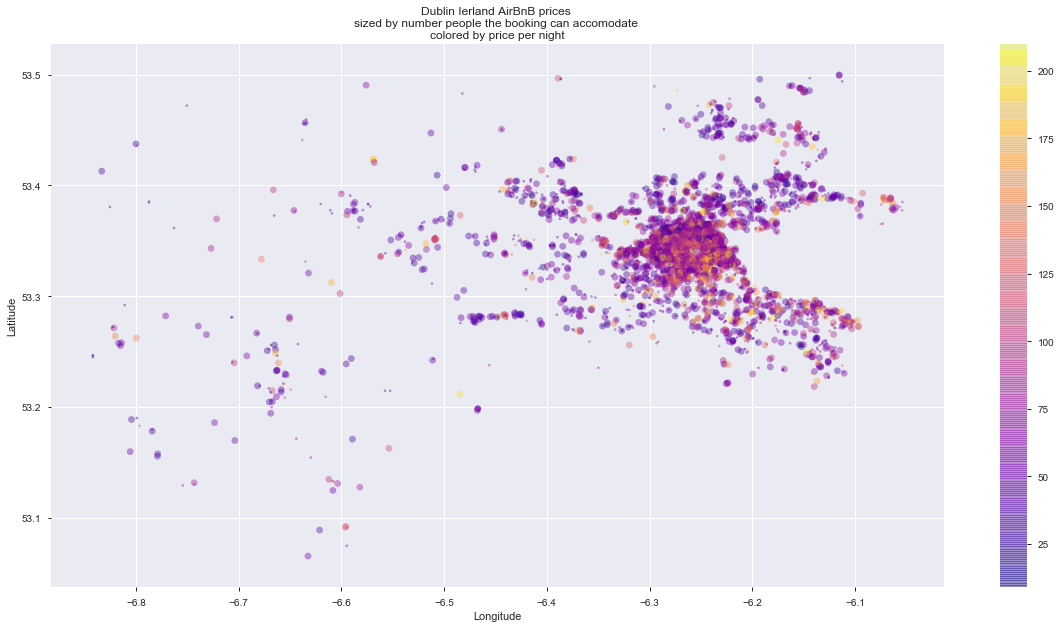

In [284]:
plt.figure(figsize=(20,10))
scatter = plt.scatter(
    x=dublin_city['longitude'], y=dublin_city['latitude'], 
    alpha=0.4, s=dublin_city['accommodates'], sizes=(5,40), 
    c=dublin_city['price'], cmap=plt.get_cmap("plasma")
)
plt.colorbar(scatter)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dublin Ierland AirBnB prices \nsized by number people the booking can accomodate \ncolored by price per night');

In [350]:
sub_dublin_city = dublin_city.sample(n=1000)
sub_dublin_city.shape

(1000, 38)

In [351]:
y = sub_dublin_city['price']
X = sub_dublin_city.drop(columns=['price'])

X.shape, y.shape

((1000, 37), (1000,))

In [353]:
X = encoder.transform(X)

In [354]:
y_pred = rf_best.predict(X)

In [355]:
rf_mae_sub = mean_absolute_error(y, y_pred)
rf_rmse_sub = math.sqrt(mean_squared_error(y, y_pred))
rf_r2_sub = r2_score(y, y_pred)

print(f"MAE: {rf_mae_sub}")
print(f"RMSE: {rf_rmse_sub}")
print(f"R2: {rf_r2_sub}\n")

MAE: 9.393847857142857
RMSE: 14.379301736775847
R2: 0.8912144079916684



In [357]:
sub_dublin_city['predicted_price'] = y_pred

In [368]:
sub_dublin_city[['price', 'predicted_price']] = sub_dublin_city[['price', 'predicted_price']].round(0)

In [371]:
sub_dublin_city['price_dif'] = sub_dublin_city['price'] - sub_dublin_city['predicted_price']

In [374]:
sub_dublin_city[['price', 'predicted_price', 'price_dif']].describe()

price  predicted_price    price_dif
count  1000.000000      1000.000000  1000.000000
mean     86.342000        86.260000     0.082000
std      43.618363        37.581255    14.384791
min      11.000000        23.000000   -69.000000
25%      50.000000        56.000000    -7.000000
50%      79.000000        77.000000    -1.000000
75%     110.000000       113.000000     6.000000
max     205.000000       192.000000   123.000000

In [406]:
def value(x):
    if x <= -10:
        return 'good value'
    if x <= 10:
        return 'fair value'
    else:
        return 'poor value'

In [407]:
sub_dublin_city['value'] = sub_dublin_city['price_dif'].apply(lambda x: value(x))

In [408]:
sub_dublin_city[['price', 'predicted_price', 'price_dif', 'value']].head()

price  predicted_price  price_dif       value
236     90.0             97.0       -7.0  fair value
13858   77.0             92.0      -15.0  good value
7170    45.0             47.0       -2.0  fair value
6285   130.0            126.0        4.0  fair value
18195  115.0            113.0        2.0  fair value

In [409]:
sub_dublin_city['value'].value_counts() * 100 / len(sub_dublin_city)

fair value    68.7
good value    16.7
poor value    14.6
Name: value, dtype: float64

In [418]:
def map_color(x):
    if x == 'good value':
        return 'green'
    if x == 'fair value':
        return 'orange'
    else:
        return 'red'

In [419]:
sub_dublin_city['color'] = sub_dublin_city['value'].apply(lambda x: map_color(x))

In [420]:
lon = sub_dublin_city['longitude'].tolist()
lat = sub_dublin_city['latitude'].tolist()
actual_price = sub_dublin_city['price'].tolist()
accommodates = sub_dublin_city['accommodates'].tolist()
predicted_price = sub_dublin_city['predicted_price'].tolist()
value = sub_dublin_city['value'].tolist()
color = sub_dublin_city['color'].tolist()

In [484]:
stats.median(sub_dublin_city['longitude'])

-6.261745

In [483]:
m = folium.Map(
        location=[53.35, -6.27],
        tiles = "Stamen Terrain",
        zoom_start=8
)

for i in range(len(sub_dublin_city)):
    
    popup_text = f'actual price = €{str(actual_price[i])} -- predicted price = €{str(predicted_price[i])} -- {value[i]}'
    
    folium.CircleMarker(
        location=[lat[i], lon[i]],
        radius=actual_price[i] / 10,
        popup=folium.Popup(popup_text, max_width=150),
        color=color[i],
        fill=True,
        fill_color=color[i]
    ).add_to(m)

m

In [422]:
m.save('Dublin_AirBnB_Value_Map.html')

# function to get maps for listed markets

In [443]:
listings_cleaned['market'].value_counts()

Dublin                   6450
Other (International)    5231
Galway                   2083
Cork                      807
Donegal                   575
West Cork                 559
Tralee                    553
Dingle                    545
Limerick                  433
Castlebar                 424
Drogheda                  418
Kilkenny                  417
Waterford                 388
Wicklow                   369
Sligo                     358
Connemara                 345
Wexford                   284
Londonderry               210
Carlow                    178
Dundalk                   165
Thurles                    92
Mullingar                  89
Roscommon                  65
Banagher                   11
Argyll                      9
Cavan                       5
Other (Domestic)            1
Enniskillen                 1
Name: market, dtype: int64

In [444]:
# list of markets / cities to make maps for
markets = [
    'Galway',
    'Cork',
    'Donegal',
    'Limerick'
]

In [491]:
def create_maps(lst, main_df, col_name, target, model):
    """
    takes a list of markets to create folium maps from.
    uses lists of markets, the dataframe with all data, column name
    to filter, target column for model
    
    lst: list of markets to filter from main df
    main_df: pandas df with all data
    col_name: column name in main df with values that are in list
    target: column name of target for predictive model
    best: tuned model for predictions 
    
    return: nothing, saves maps for each market / city
    """
    # create list to hold maps
    maps = []
    
    # loop list: filter by element, sample if needed, predict price,
    # add value labels, build and save maps
    for x in lst:
        # create df filtered by list element
        df = main_df[main_df[col_name] == x]
        
        # check to see if there are over 1000 listings, if so sample 1000
        if len(df) > 1000:
            df = df.sample(n=1000)

        # pipeline for regressor
        rf = Pipeline(steps=[
            ('regressor', model)
        ])
        # split df into X features and y target
        y = df[target]
        X = df.drop(columns=target)
        
        X = encoder.transform(X)

        # predict target
        y_pred = rf.predict(X)
        
        
        # add prediction to df
        df['predicted_price'] = y_pred
        df['predicted_price'] = df['predicted_price'].round(0)
        
        # create difference column for df
        df['price_dif'] = df['price'] - df['predicted_price']
        
        # add value and color to df
        def value(x):
            if x <= -10:
                return 'good value'
            if x <= 10:
                return 'fair value'
            else:
                return 'poor value'
            
        
        def map_color(x):
            if x == 'good value':
                return 'green'
            if x == 'fair value':
                return 'orange'
            else:
                return 'red'
            
        df['value'] = df['price_dif'].apply(lambda x: value(x))
        df['color'] = df['value'].apply(lambda x: map_color(x))
        
        # set folium map variables
        lat = df['latitude'].tolist()
        lon = df['longitude'].tolist()
        actual_price = df['price'].tolist()
        accommodates = df['accommodates'].tolist()
        predicted_price = df['predicted_price'].tolist()
        value = df['value'].tolist()
        color = df['color'].tolist()
        
        # create map
        m = folium.Map(
            location=[stats.median(lat), stats.median(lon)],
            tiles = "Stamen Terrain",
            zoom_start=12
        )
        
        # add markers to map
        for i in range(len(df)):
            popup_text = f'actual price = €{str(actual_price[i])} -- predicted price = €{str(predicted_price[i])} -- {value[i]}'

            folium.CircleMarker(
                location=[lat[i], lon[i]],
                radius=actual_price[i] / 10,
                popup=folium.Popup(popup_text, max_width=150),
                color=color[i],
                fill=True,
                fill_color=color[i]
            ).add_to(m)
        
        # save maps
        m.save(f'{x}_value_map.html')


In [492]:
create_maps(markets, listings_cleaned, 'market', 'price', rf_best)